The above header is for creating a nicely-formatted `.html` and `.pdf` documents using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html` and `.pdf` versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-30.ipynb 

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-30.ipynb`
- Continued from: ---
- Continued to: `dissipation-theory--Study-31.ipynb`

# Preliminaries

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cycler

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.capacitance import Csphere

In [4]:
THIS = 'dissipation-theory--Study-30--'
figs = {}

# Plot the capacitance of a sphere over a metal

In [5]:
r = ureg.Quantity(30, 'nm')
h = ureg.Quantity(
    np.logspace(
        start=np.log10(10e-9),
        stop=np.log10(1e-6),
        num=20,
        endpoint=True), 
    'm')

In [6]:
def plotC(h, r):

    Cfar = (4 * np.pi * epsilon0 * r * np.ones(len(h))).to('pF') 
    Capprox = Csphere(0, h, r).to('pF')
    
    fig, ax = plt.subplots(figsize=(3.25, 2.5))
    opts = {'marker': 'o', 'facecolors': 'none', 'edgecolors': 'black'}
    plt.scatter(
        h.to('nm').magnitude,
        Capprox.to('aF').magnitude,
        **opts)
    plt.plot(
        h.to('nm').magnitude,
        Cfar.to('aF').magnitude , 
        'k--')
    plt.xscale('log')
    plt.xlabel('$h$ [nm]')
    plt.ylabel('$C$ [aF]')

    fig.tight_layout()
    
    return fig

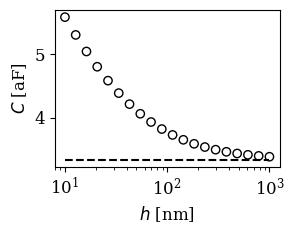

In [7]:
#| fig-cap: > 
#|  Capacitance $C$ versus height $h$ for a radius $r = 30$ nm 
#|  sphere over a ground plane (circles).  For comparison, we plot 
#|  $C_{\mathrm{sphere}} = 2 \pi \epsilon_0 r$, the capacitance at
#|  infinite height (dotted line).

figs['01'] = plotC(h,r)

# Compute the capacitance numerically

Start with the sphere far away.

Print out the smallest and largest tip-sample separation, in nm, from the above plot.

In [8]:
[round(h[k].to('nm').magnitude) for k in [0,-1]]

[10, 1000]

Use the tip radius from above.  

In [9]:
print(r)

30 nanometer


Set the tip-sample separation $d$ to be far away.

In [10]:
d = ureg.Quantity(1000, 'nm')

Create a collection of vectors $r_j = (0, z_j)$ points inside the sphere.  Make the number of points `Nz` odd so the center of the sphere is one of the points.

In [11]:
Nz = 21
delta_array = np.linspace(start=-0.80, stop=0.80, endpoint=True, num=Nz)
rj = np.array([
    [0, 
     (d + r * delta).to('nm').magnitude] for delta in delta_array])

In [12]:
rj.shape

(21, 2)

Create a collection of vectors $r_k$ points around the circumference of the sphere.  The points start at the south pole and rotate counterclockwise.

In [13]:
Nr = 100
theta_array = np.linspace(start=-np.pi/2, stop=3*np.pi/2, endpoint=False, num=Nr)
rk = np.array([
    [(r * np.cos(theta)).to('nm').magnitude, 
     (d + r * np.sin(theta)).to('nm').magnitude] for theta in theta_array])

In [14]:
rk.shape

(100, 2)

Plot the points

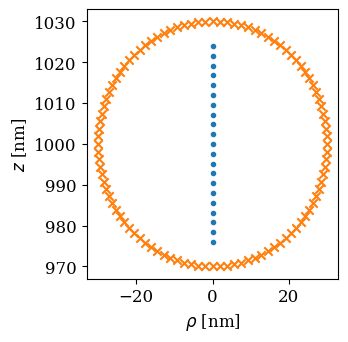

In [15]:
plt.scatter(rj[:,0], rj[:,1], marker='.')
plt.scatter(rk[:,0], rk[:,1], marker='x')
plt.xlabel(r'$\rho$ [nm]')
plt.ylabel('$z$ [nm]')
plt.show()

Compute the reaction matrix, **ignoring the image charge**.

In [16]:
dx = np.outer(np.ones_like(rk[:,0]), rj[:,0].T) - np.outer(rk[:,0], np.ones_like(rj[:,0]).T)
dz = np.outer(np.ones_like(rk[:,1]), rj[:,1].T) - np.outer(rk[:,1], np.ones_like(rj[:,1]).T)

R = 1/np.sqrt(dx * dx + dz * dz)

The array look like what I would expect.

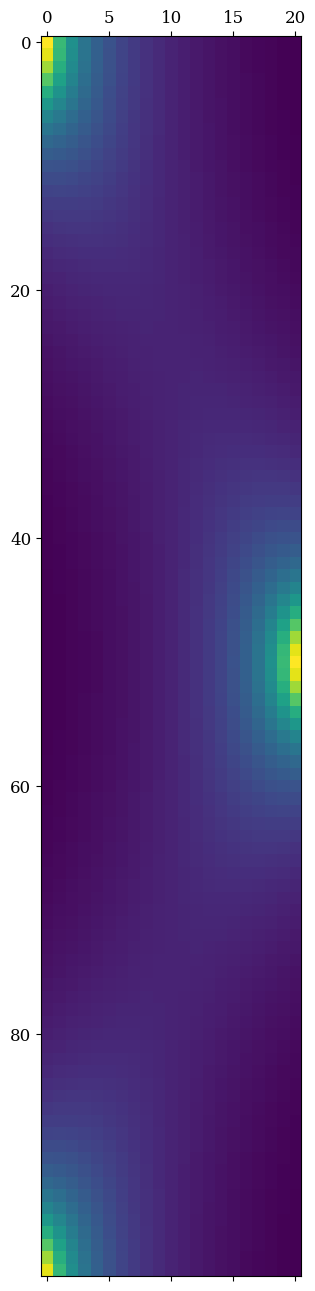

In [17]:
plt.matshow(R)
plt.show()

Compute the charges using the simple linear-algebra inverse.

In [18]:
q = np.dot(np.dot(np.linalg.inv(np.dot(R.T, R)), R.T), np.ones(Nr))
q

array([-2.57764179e+03,  2.69350330e+04, -1.33189023e+05,  4.16882116e+05,
       -9.34537746e+05,  1.59269012e+06, -2.11741495e+06,  2.21536284e+06,
       -1.81969697e+06,  1.15607790e+06, -5.51746222e+05,  1.89317236e+05,
       -4.39076171e+04,  6.33756718e+03, -5.14144377e+02,  8.41551288e+00,
        1.20454412e+01, -4.07596169e+00,  4.91302358e-01, -2.35191223e-02,
        9.60350037e-04])

The solution is not very good.  $R \cdot q$ is close to 1 near the north pole but not at the south pole.  Why the assymetry?

In [19]:
def plotRq(theta_array, R, q):
    
    fig, ax = plt.subplots(figsize=(3.25, 2.5))
    dRq = (np.dot(R,q) - 1)
    plt.plot((180 /np.pi) * theta_array, dRq)
    plt.ylabel(r'$\Delta V$')
    plt.xlabel(r'$\theta$ [degress]')
    return fig

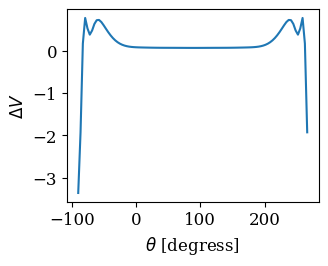

In [20]:
_ = plotRq(theta_array, R, q)

The charges are not what I would expect: positive and centered in the middle of the sphere.  Instead, the charges wildly oscillate.

In [21]:
def plotq(rj, q):

    fig, ax = plt.subplots(figsize=(3.25, 2.5))
    plt.plot(rj[:,1], q)
    plt.xlabel('$(r_j)_{z}$ [nm]')
    plt.ylabel('$q$ [a.u.]')
    return fig

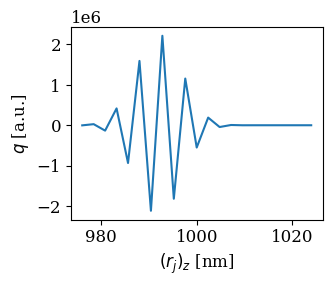

In [22]:
_ = plotq(rj, q)

Try another inversion method, singular-value decomposition.

In [23]:
U, S, VT = np.linalg.svd(R, full_matrices=False)
Rinv = np.dot(np.dot(VT.T, np.diag(np.power(S, -1))), U.T)

In [24]:
q = np.dot(Rinv, np.ones(Nr)) 

Now the errors in the potential are very small.

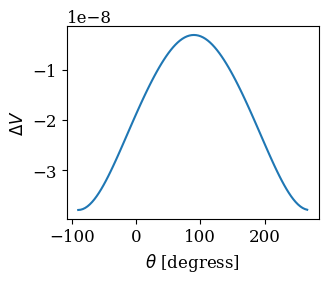

In [25]:
_ = plotRq(theta_array, R, q)

And the charge is located at the center of the sphere as I would expect.

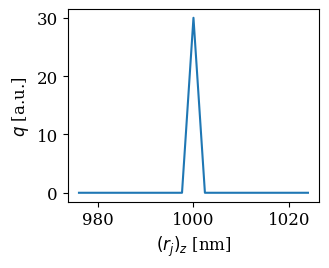

In [26]:
_ = plotq(rj, q)

Three cheers for singular value decomposition!

Finally, compute the capacitance, in arbitrary units.

In [39]:
np.dot(q, np.ones(Nz))

29.999999418149173

# Automate the calculation

In the code below, add in the image charge.  First, there are a bunch of constants we want to compute.

In [40]:
const = qe / (4 * np.pi * epsilon0 * ureg.Quantity(1, 'V') * ureg.Quantity(1, 'nm'))
const.to('')

<Quantity(1.439964544247546, 'dimensionless')>

In [29]:
1/const.to('')

<Quantity(0.6944615435115108, 'dimensionless')>

In [30]:
(qe/ureg.Quantity(1, 'V')).to('aF')

<Quantity(0.16021766299999995, 'attofarad')>

The following function numerically computes the images charges and the capacitance for a sphere above a metal ground plane.

In [31]:
def Cnum(r, d, Nz, Nr, alpha=0.):

    # reverse the z coordinate for the image charge
    delta_array = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=Nz)
    rjp = np.array([
        [0, 
         (d + r + r * delta).to('nm').magnitude] for delta in delta_array])
    rjm = np.array([
        [0, 
         (-d -r - r * delta).to('nm').magnitude] for delta in delta_array])
    
    theta_array = np.linspace(start=-np.pi/2, stop=3*np.pi/2, endpoint=False, num=Nr)

    rk = np.array([
        [(r * np.cos(theta)).to('nm').magnitude, 
         (d + r + r * np.sin(theta)).to('nm').magnitude] for theta in theta_array])
    
    dxp = np.outer(np.ones_like(rk[:,0]), rjp[:,0].T) - np.outer(rk[:,0], np.ones_like(rjp[:,0]).T)
    dzp = np.outer(np.ones_like(rk[:,1]), rjp[:,1].T) - np.outer(rk[:,1], np.ones_like(rjp[:,1]).T)

    dxm = np.outer(np.ones_like(rk[:,0]), rjm[:,0].T) - np.outer(rk[:,0], np.ones_like(rjm[:,0]).T)
    dzm = np.outer(np.ones_like(rk[:,1]), rjm[:,1].T) - np.outer(rk[:,1], np.ones_like(rjm[:,1]).T)
    
    R = 1.43996 * (1/np.sqrt(dxp * dxp + dzp * dzp) 
                 - 1/np.sqrt(dxm * dxm + dzm * dzm))

    U, S, VT = np.linalg.svd(R, full_matrices=False)

    filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
    Sinv = filt * np.diag(np.power(S, -1)) 
    Rinv = np.dot(np.dot(VT.T, Sinv), U.T)

    q = np.dot(Rinv, np.ones(Nr))  # electrons
    C = 0.16022 * q.sum()          # aF

    result = {'rjz': rjp[:,1], 
              'theta': theta_array, 
              'r': r.to('nm').magnitude,
              'd': d.to('nm').magnitude, 
              'R': R,
              'q':q, 
              'C': C, 
              'S': S, 
              'rjp': rjp, 
              'rjm': rjm, 
              'rk': rk}
    
    return result

In [79]:
def plotresult(result):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8.00, 2.5))

    dRq = 1e6 * (np.dot(result['R'], result['q']) - 1)

    fig.suptitle('r = {:0.1f} nm, h = {:0.1f} nm, C = {:0.3f} aF'.format(
        result['r'],
        result['d'],
        result['C']), fontsize=10)

    cmap = plt.get_cmap('RdBu')
    values = result['q']
    ax1.scatter(result['rjp'][:,0], result['rjp'][:,1], 
        marker='.', c=values, cmap=cmap, 
        alpha=0.5, edgecolors='face',
        vmin=-max(abs(values)), vmax=max(abs(values)))
    ax1.scatter(result['rk'][:,0], result['rk'][:,1], marker='.')
    ax1.set_xlabel(r'$\rho$ [nm]')
    ax1.set_ylabel('$z$ [nm]')
    ax1.axis('equal')
    
    ax2.plot((180 /np.pi) * result['theta'], dRq, '.-')
    ax2.set_ylabel(r'$\Delta V$ [ppm]')
    ax2.set_xlabel(r'$\theta$ [degress]')
    
    ax3.plot(result['rjz'], result['q'], '.-')
    ax3.set_xlabel('$(r_j)_{z}$ [nm]')
    ax3.set_ylabel('$q/q_{e}$')
    ax3.set_title(r''.format(), fontsize=10)

    ax4.plot(result['S'])
    ax4.set_ylabel('singular values')
    ax4.set_yscale('log')
    
    fig.tight_layout()
    
    return fig

Start far away and work towards the surface.

In [80]:
(Nz, Nr) = (21, 42)

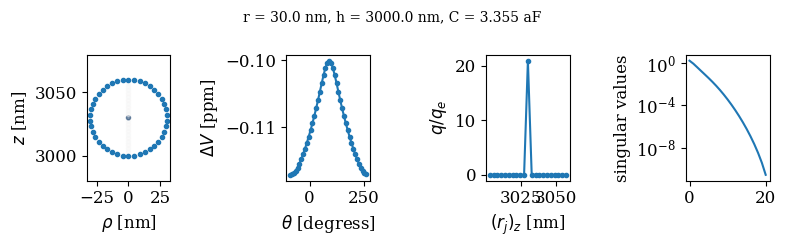

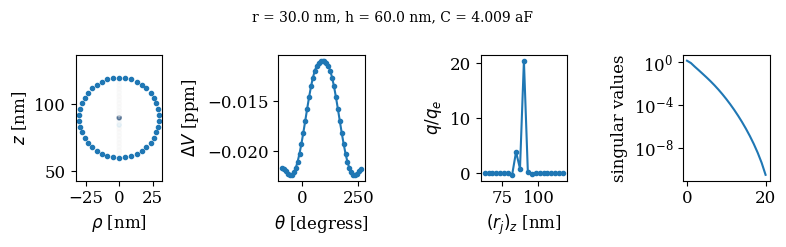

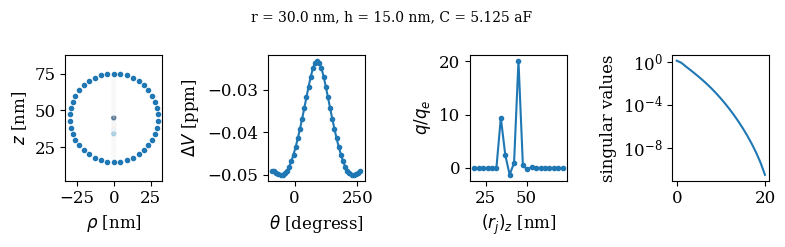

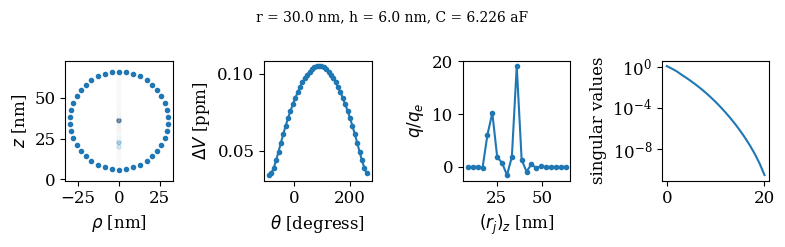

In [81]:
for hval, figname in zip([100.0*r, 2.0*r, 0.5*r, 0.2*r], ['02', '03', '04', '05']):
    result = Cnum(r, hval, Nz, Nr)
    figs[figname] = plotresult(result)

# Quantitative comparison

In [82]:
def compare(r, h, Nz, Nr):
    
    C0 = Csphere(0, h, r).to('aF').magnitude
    C1 = np.zeros(len(h))
    
    for index, hval in enumerate(h):
        result = Cnum(r, hval, Nz, Nr) 
        C1[index] = result['C']
        
    df = pd.DataFrame.from_dict(
        {'h [nm]': h.to('nm').magnitude, 
         'C0 [aF]': C0, 
         'C1 [aF]': C1,
         'err [ppm]': 1e6 * (C0-C1)/C1})
    
    return df

In [83]:
df = compare(r, h, Nz, Nr)
df

,h [nm],C0 [aF],C1 [aF],err [ppm]
0,10.000000,5.582016,5.582115,-17.886915
1,12.742750,5.302472,5.302566,-17.736872
2,16.237767,5.041958,5.042047,-17.664626
3,20.691381,4.801947,4.802032,-17.747132
4,26.366509,4.583591,4.583672,-17.548267
5,33.598183,4.387608,4.387686,-17.807460
6,42.813324,4.214178,4.214253,-17.764718
7,54.555948,4.062903,4.062975,-17.687060
8,69.519280,3.932814,3.932883,-17.688499
9,88.586679,3.822449,3.822517,-17.695560


In [84]:
def compareplot(df):

    fig, (ax1, ax2) = plt.subplots(2, 1, 
        figsize=(3.25, 4.0), sharex=True, 
        gridspec_kw={'height_ratios': [1, 3]}) 
    
    opts1 = {'marker': 'o', 'facecolors': 'none', 'edgecolors': 'black'}
    opts2 = {'marker': '.'}

    ax1.scatter(df['h [nm]'], df['err [ppm]'], **opts1)
    ax2.scatter(df['h [nm]'], df['C0 [aF]'], **opts1)
    ax2.scatter(df['h [nm]'], df['C0 [aF]'], **opts2)
    
    ax1.set_ylabel(r'$\epsilon$ [ppm]')
    ax2.set_ylabel('$C$ [aF]')
    ax2.set_xlabel('$h$ [nm]')
    ax2.set_xscale('log')

    fig.align_ylabels()
    fig.tight_layout()
    
    return fig

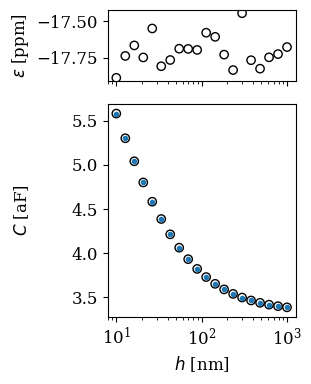

In [85]:
figs['06'] = compareplot(df)

# Save figures

In [ ]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')